In [1]:
import sys
sys.path.append('../')

import numpy as np
import random
import torch
import gpytorch
from gp_mjo.gp_mjo_model import gp_mjo
from gp_mjo.utils.dat_ops import dics_divide, dat_divide

from matplotlib import pyplot as plt
import matplotlib.colors as mcolors

%matplotlib inline
%load_ext autoreload
%autoreload 2

### Load the updated dataset

In [2]:
npzfile = np.load('../data/mjo_new_data.npz', allow_pickle=True)

data_names = npzfile.files
n_files = len(npzfile.files)

new_datas = [0]*n_files
for i in range(n_files):
    new_datas[i] = npzfile[data_names[i]]

print(npzfile.files)
print(npzfile['RMM1'])
print(npzfile['RMM2'])
print(npzfile['year'])
print(npzfile['month'])
print(npzfile['day'])

print(data_names)
print(new_datas)

['year', 'month', 'day', 'RMM1', 'RMM2', 'phase', 'amplitude']
[ 0.142507   -0.2042     -0.15861    ...  0.63895518  0.71995491
  0.67032343]
[ 1.05047     1.37361     1.53943    ... -0.39565107 -0.2206952
 -0.1839911 ]
[1979 1979 1979 ... 2022 2022 2022]
[ 1  1  1 ... 11 11 11]
[ 1  2  3 ... 14 15 16]
['year', 'month', 'day', 'RMM1', 'RMM2', 'phase', 'amplitude']
[array([1979, 1979, 1979, ..., 2022, 2022, 2022]), array([ 1,  1,  1, ..., 11, 11, 11]), array([ 1,  2,  3, ..., 14, 15, 16]), array([ 0.142507  , -0.2042    , -0.15861   , ...,  0.63895518,
        0.71995491,  0.67032343]), array([ 1.05047   ,  1.37361   ,  1.53943   , ..., -0.39565107,
       -0.2206952 , -0.1839911 ]), array([6., 7., 7., ..., 4., 4., 4.]), array([1.0600899 , 1.3887    , 1.54758   , ..., 0.7515341 , 0.75302154,
       0.69511598])]


### Specify Initial Values and GP Kernel

In [3]:
## Set initial values
widths = [40, 60, 80]
n_iter = 200
sigma_eps = 0.01
fixed_noise = True

n = 10000 # the number of days for training
m = 160 # the number of days for testing
c = 365 # the number of dropped buffer set

n_cv = 1 # the number of operations for cross-validation
n1s  = [random.randint(0,n) for i in range(n_cv)]


palette_colors = list(mcolors.TABLEAU_COLORS.keys()) # list of Tableau Palette colors
plot_colors = palette_colors[:len(widths)]

## Set the kernel of GP
nu = 0.5 # 1.5,2.5.... smoothness parameter of Matern kernel
d = 1 # d = width or d = 1
kernel = gpytorch.kernels.MaternKernel(nu=nu, ard_num_dims=d) 

### Independent RMMs with differnet widths in the same plot

/Users/hchen/opt/anaconda3/envs/ml/lib/python3.10/site-packages/gpytorch/likelihoods/gaussian_likelihood.py:300: GPInputWarning: You have passed data through a FixedNoiseGaussianLikelihood that did not match the size of the fixed noise, *and* you did not specify noise. This is treated as a no-op.
  warnings.warn(


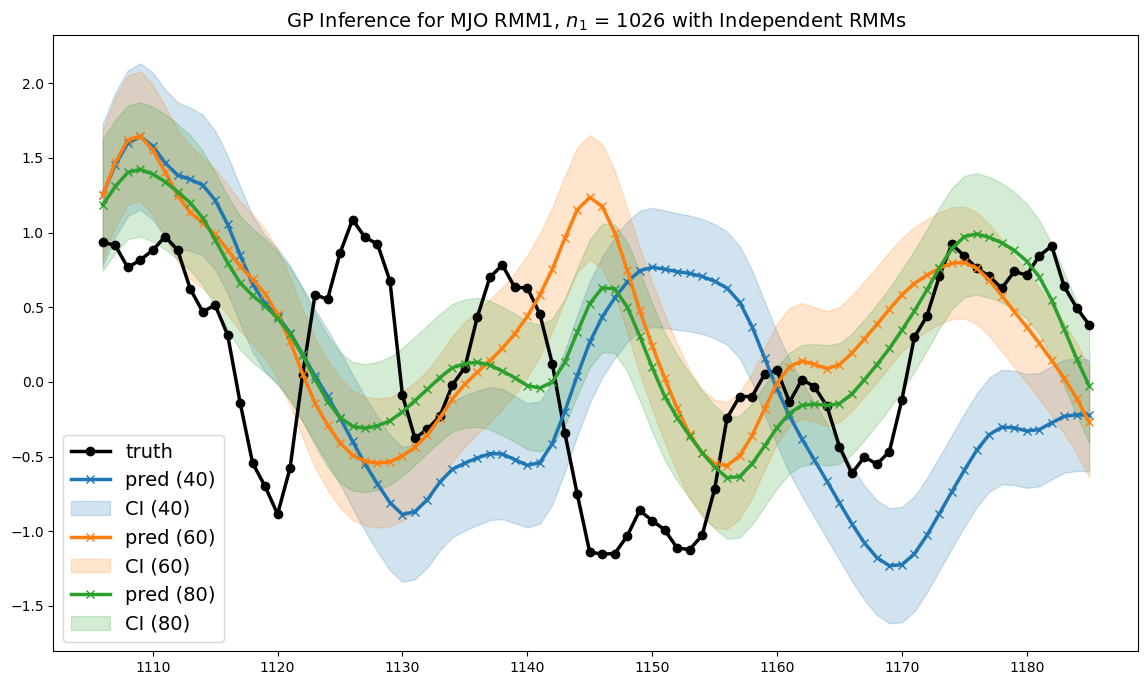

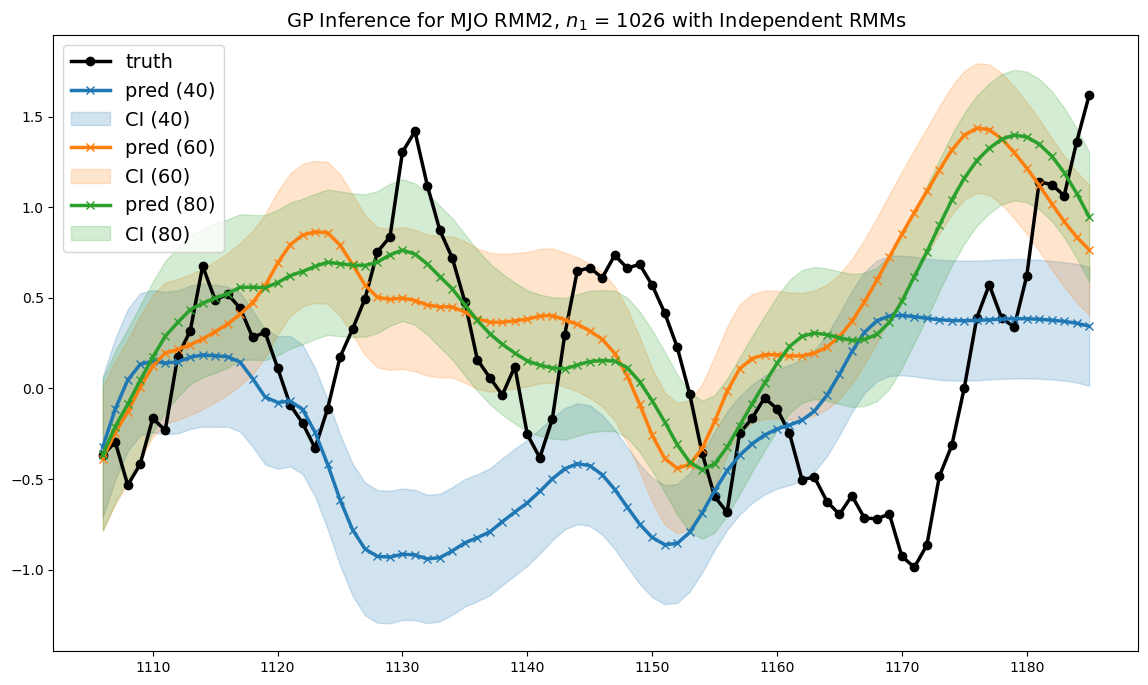

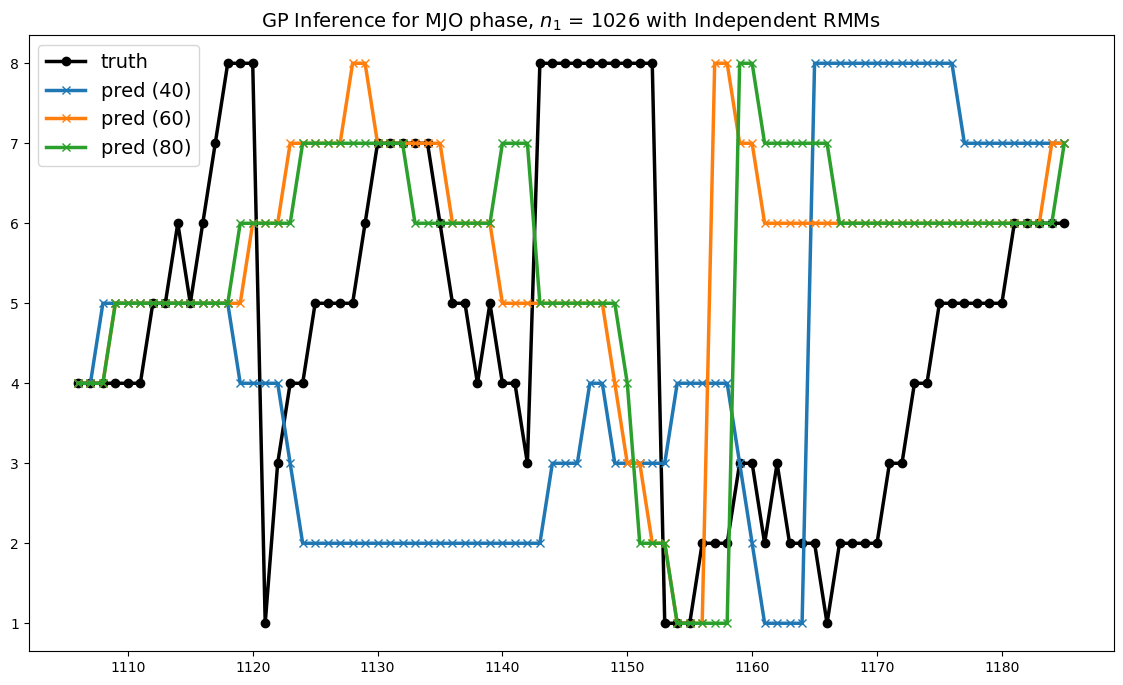

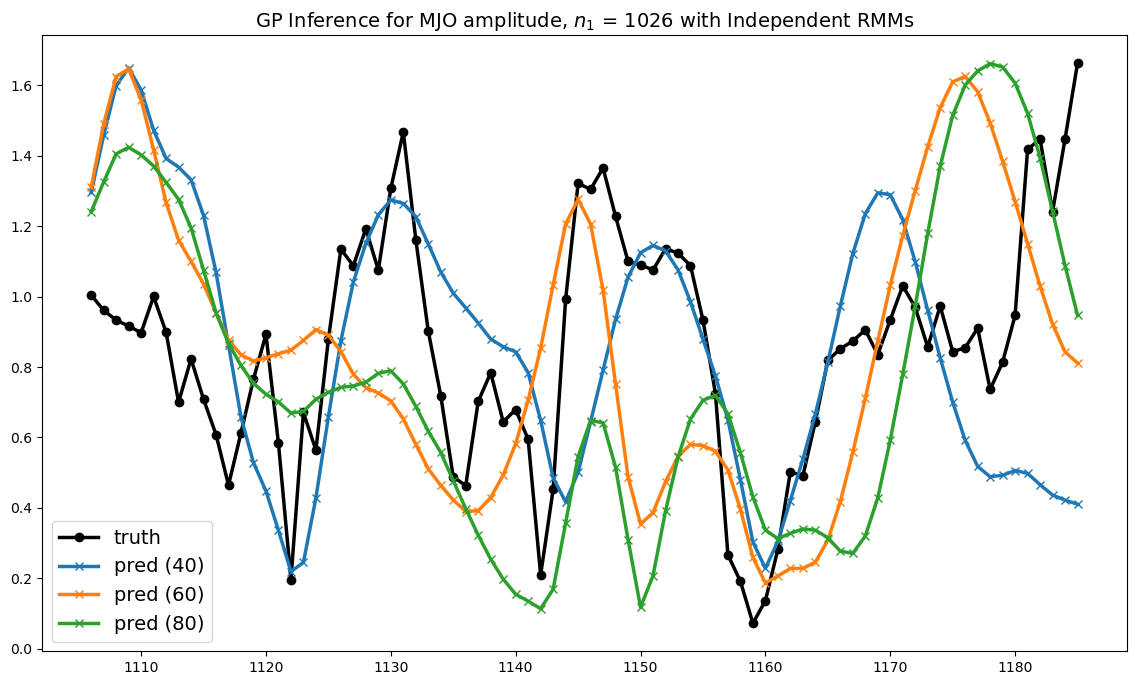

In [4]:
## Independent RMMs in the same plot
for n1 in n1s:
    start_index =  max(widths) + n1 # start_index should >= max(widths) + n1 + 1 (start from index=1)
    mjo_models = {}
    dics_widths = {}

    ## Training   
    for width in widths:    
        dics, dics_ids = dics_divide(new_datas, data_names, n1, m, n, c, fixed_start=True, start_index=start_index, width=width)
        dics_widths[width] = dics
        mjo_model = gp_mjo(dics, dics_ids, kernel, width, n_iter, sigma_eps, fixed_noise)
        
        for i in range(4): # data_names = ['year', 'month', 'day', 'RMM1', 'RMM2', 'phase', 'amplitude']
            data_name = data_names[3:][i]
            if i <= 1:
                mjo_model.train_mjo(data_name)
                mjo_model.pred_mjo(data_name) 
            if i == 2:
                mjo_model.rmm_to_phase()
            if i == 3:
                mjo_model.rmm_to_amplitude()

        mjo_models[width] = mjo_model



    ## Plot
    for i in range(4):
        data_name = data_names[3:][i]        
        fig, ax = plt.subplots(1, 1, figsize=(14, 8))
        ax.plot(np.arange(start_index,n1+m), dics_widths[widths[0]][data_name]['test'][widths[0]:], color='black', marker='o', linewidth=2.5)
        
        for width, color in zip(widths, plot_colors):           
            observed_preds = mjo_models[width].preds[data_name]
            ax.plot(np.arange(start_index,n1+m), observed_preds.reshape(-1), color, linewidth=2.5, marker='x')

            if i <= 1:
                lower_confs = mjo_models[width].lconfs[data_name]
                upper_confs = mjo_models[width].uconfs[data_name]
                ax.fill_between(np.arange(start_index,n1+m), lower_confs.reshape(-1), upper_confs.reshape(-1), alpha=0.2, color=color)
        
        if i <= 1:
            ax.legend(['truth',f'pred ({widths[0]})',f'CI ({widths[0]})', f'pred ({widths[1]})',f'CI ({widths[1]})',f'pred ({widths[2]})',f'CI ({widths[2]})'] , fontsize=14)
        else:
            ax.legend(['truth',f'pred ({widths[0]})', f'pred ({widths[1]})',f'pred ({widths[2]})'], fontsize=14)
        ax.set_title(f'GP Inference for MJO {data_name}, $n_1$ = {n1} with Independent RMMs', fontsize=14)
        plt.show()  

### Dependent RMMs with differnet widths in the same plot

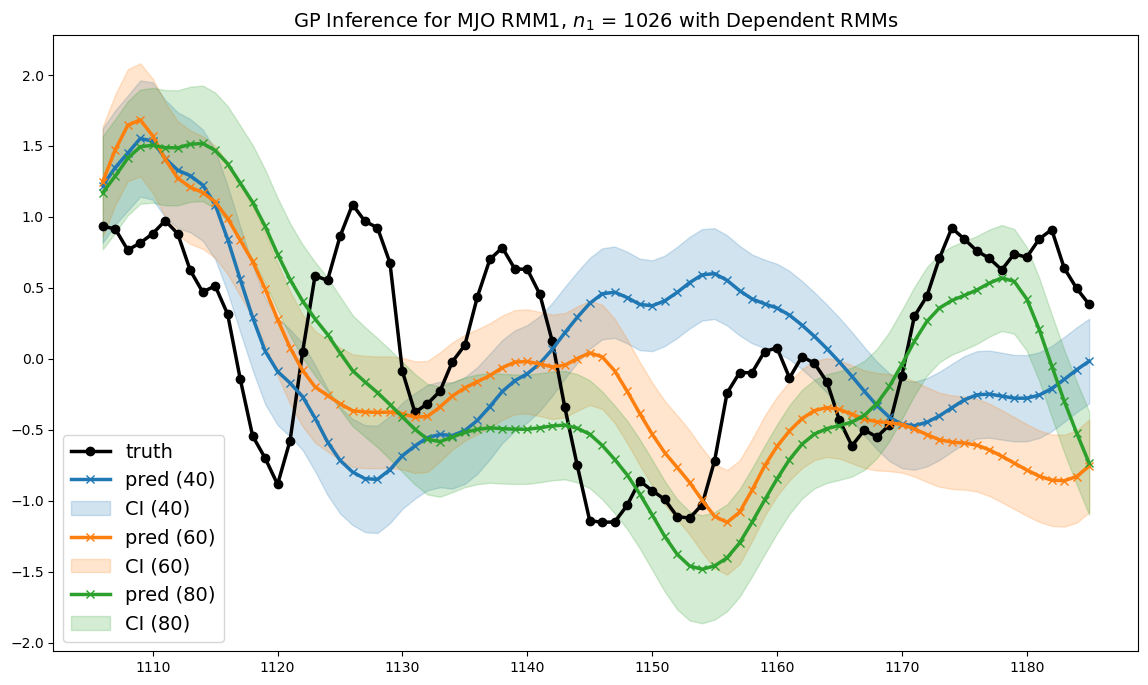

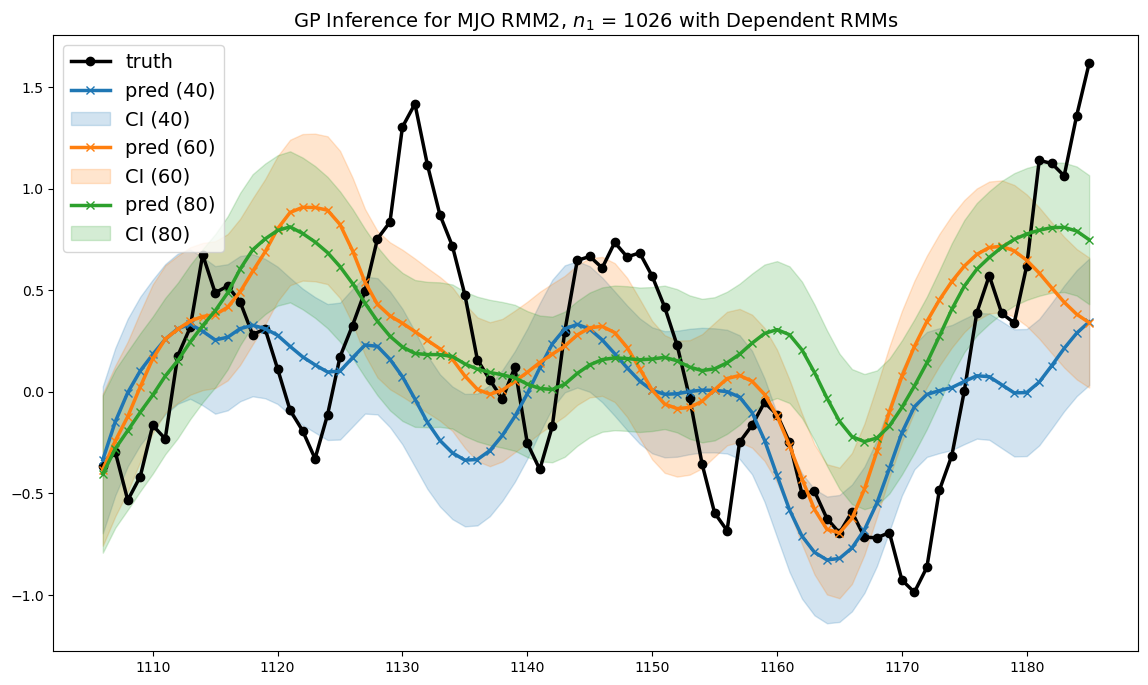

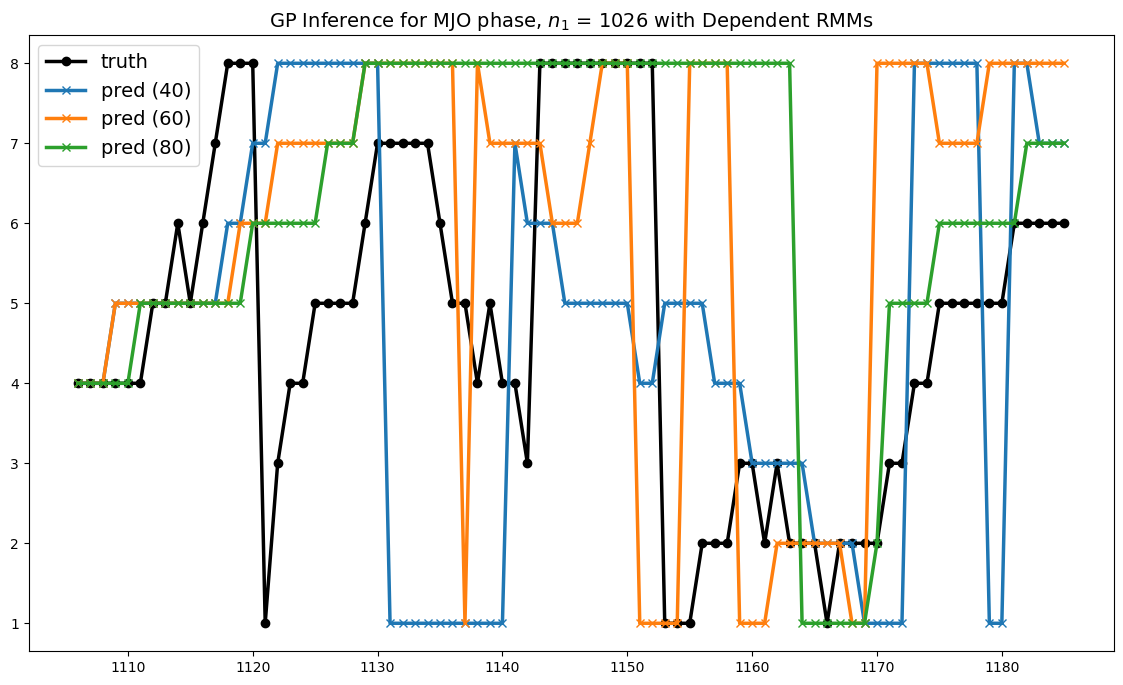

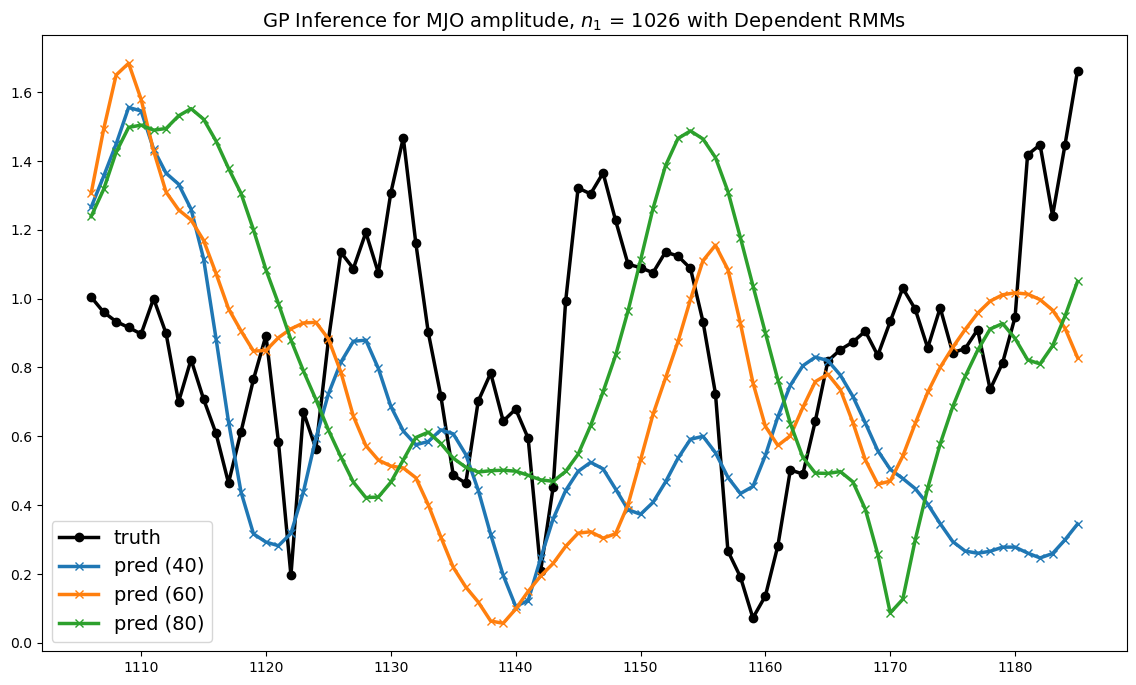

In [5]:
## Dependent RMMs in the same plot
for n1 in n1s:
    start_index =  max(widths) + n1 # start_index should >= max(widths) + n1 + 1 (start from index=1)
    mjo_models = {}
    dics_widths = {}

    ## Training   
    for width in widths:    
        dics, dics_ids = dics_divide(new_datas, data_names, n1, m, n, c, fixed_start=True, start_index=start_index, width=width)
        dics_widths[width] = dics
        mjo_model = gp_mjo(dics, dics_ids, kernel, width, n_iter, sigma_eps, fixed_noise)
        mjo_model.train_mjo(Depend=True)

        for i in range(4):  # data_names = ['year', 'month', 'day', 'RMM1', 'RMM2', 'phase', 'amplitude']
            data_name = data_names[3:][i]
            if i <= 1:                
                mjo_model.pred_mjo(data_name) 
            if i == 2:
                mjo_model.rmm_to_phase()
            if i == 3:
                mjo_model.rmm_to_amplitude()

        mjo_models[width] = mjo_model



    ## Plot
    for i in range(4):
        data_name = data_names[3:][i]        
        fig, ax = plt.subplots(1, 1, figsize=(14, 8))
        ax.plot(np.arange(start_index,n1+m), dics_widths[widths[0]][data_name]['test'][widths[0]:], color='black', marker='o', linewidth=2.5)
        
        for width, color in zip(widths, plot_colors):           
            observed_preds = mjo_models[width].preds[data_name]
            ax.plot(np.arange(start_index,n1+m), observed_preds.reshape(-1), color, linewidth=2.5, marker='x')

            if i <= 1:
                lower_confs = mjo_models[width].lconfs[data_name]
                upper_confs = mjo_models[width].uconfs[data_name]
                ax.fill_between(np.arange(start_index,n1+m), lower_confs.reshape(-1), upper_confs.reshape(-1), alpha=0.2, color=color)
        
        if i <= 1:
            ax.legend(['truth',f'pred ({widths[0]})',f'CI ({widths[0]})', f'pred ({widths[1]})',f'CI ({widths[1]})',f'pred ({widths[2]})',f'CI ({widths[2]})'] , fontsize=14)
        else:
            ax.legend(['truth',f'pred ({widths[0]})', f'pred ({widths[1]})',f'pred ({widths[2]})'], fontsize=14)
        ax.set_title(f'GP Inference for MJO {data_name}, $n_1$ = {n1} with Dependent RMMs', fontsize=14)
        plt.show()  

### Independent RMMs Examples

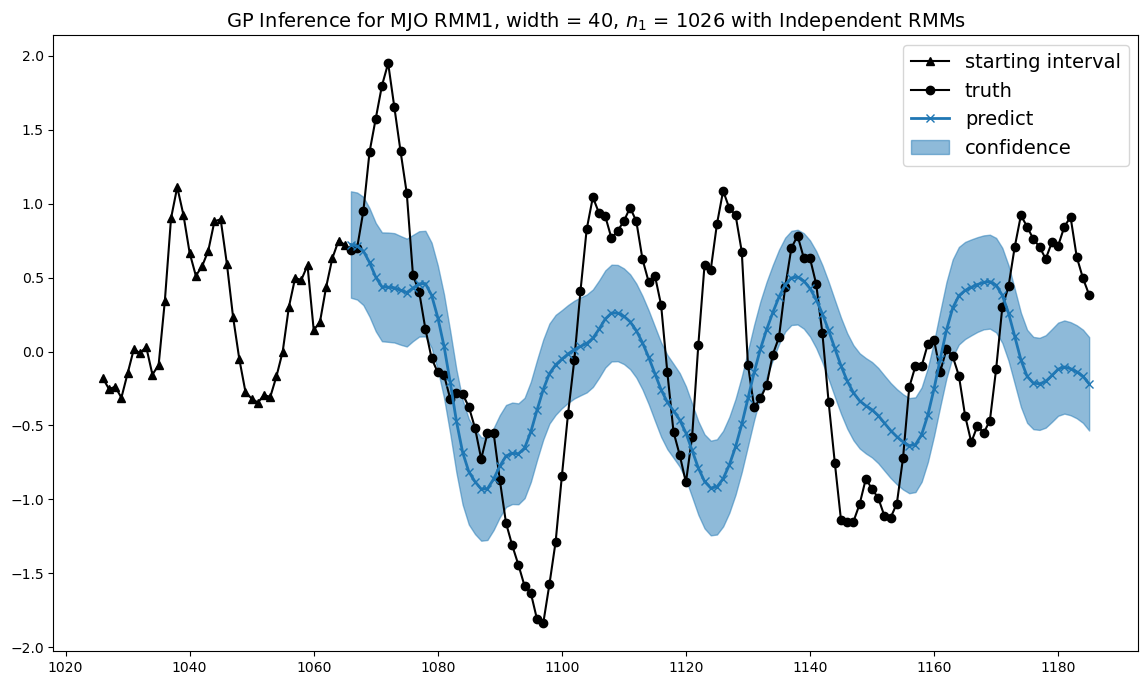

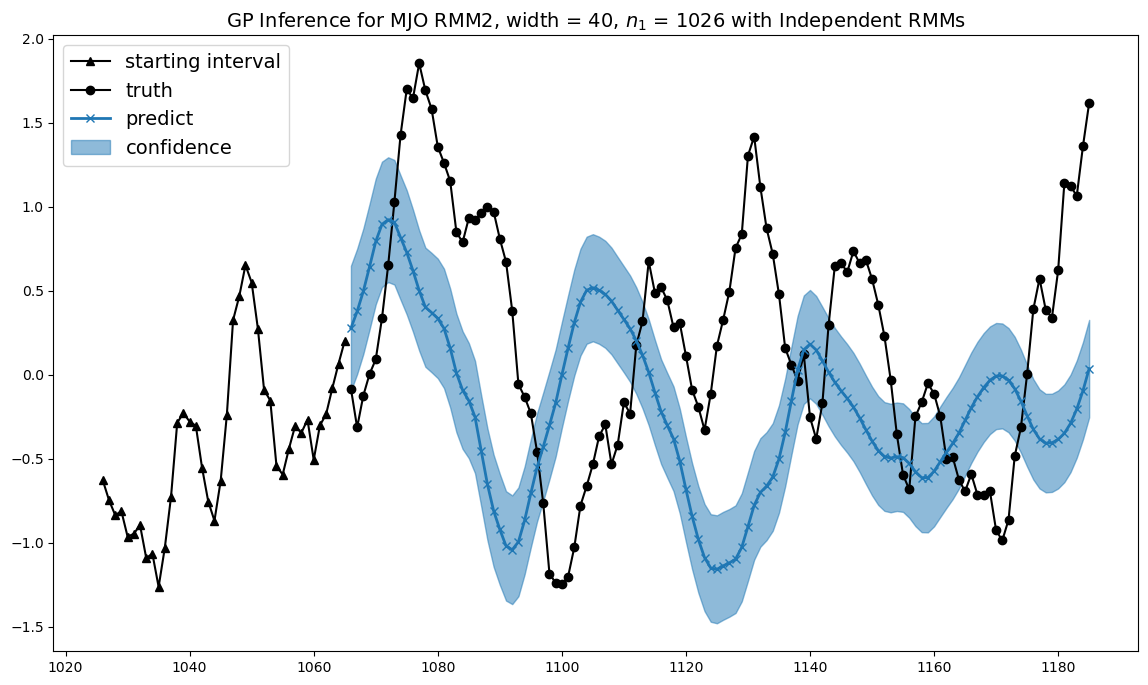

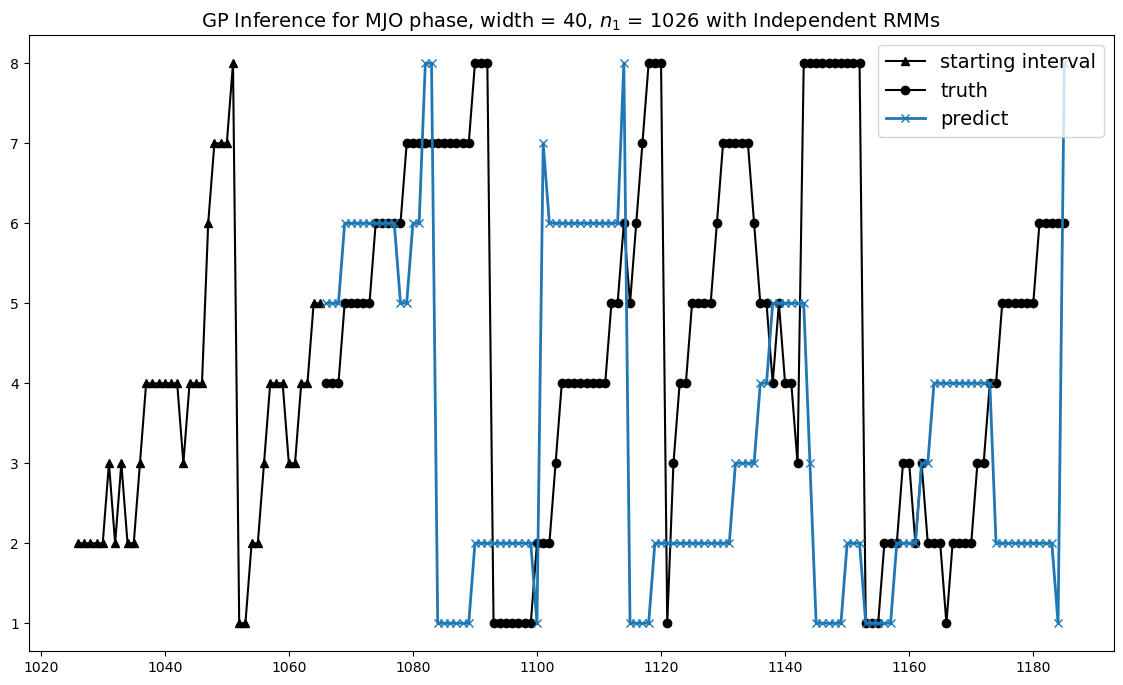

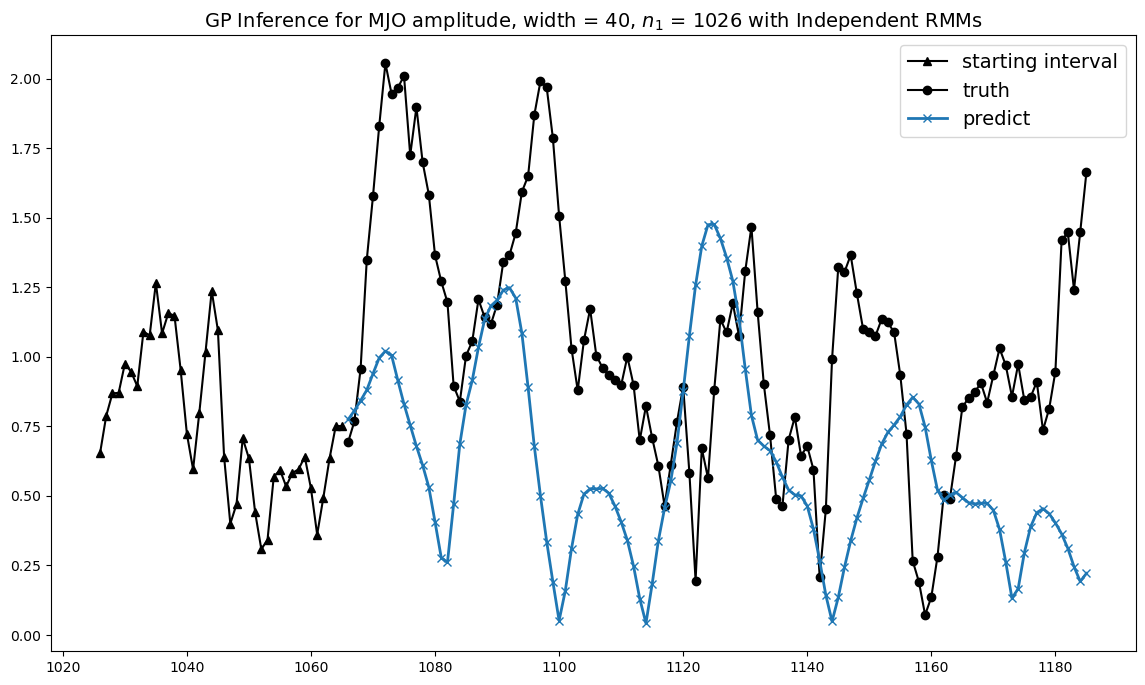

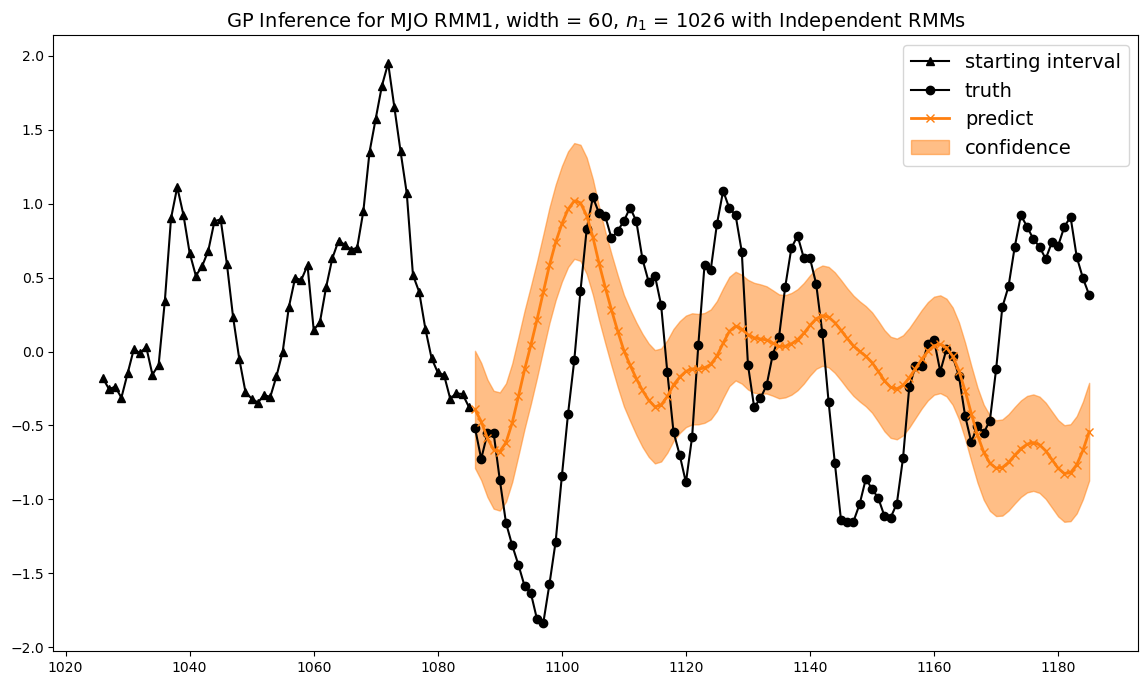

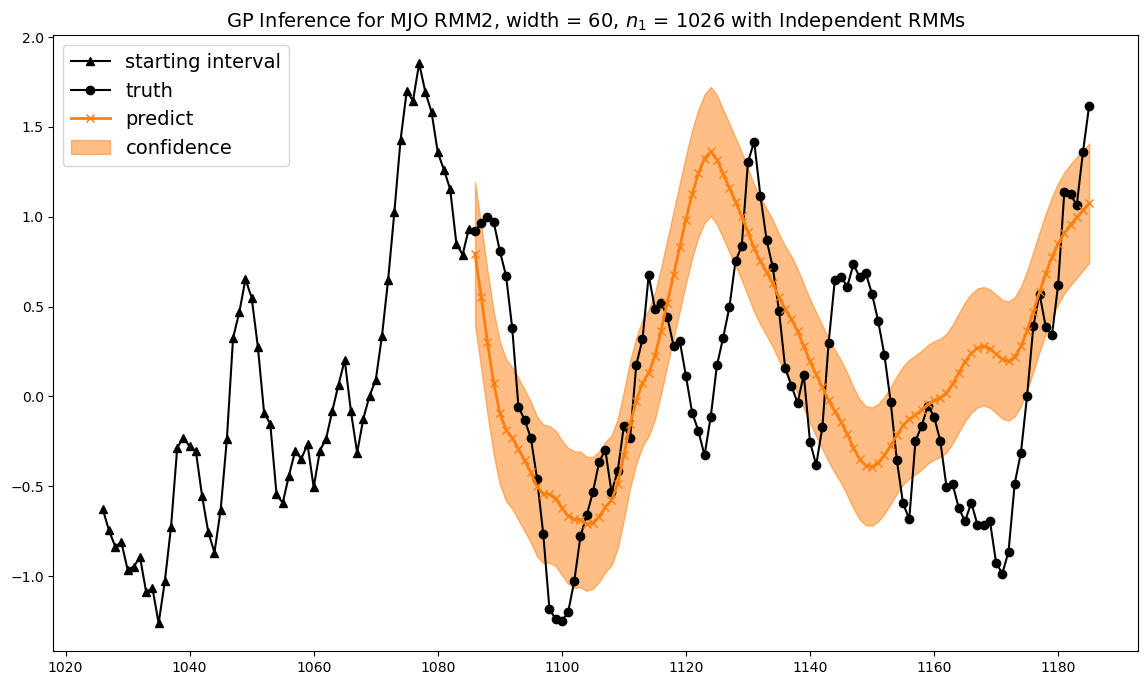

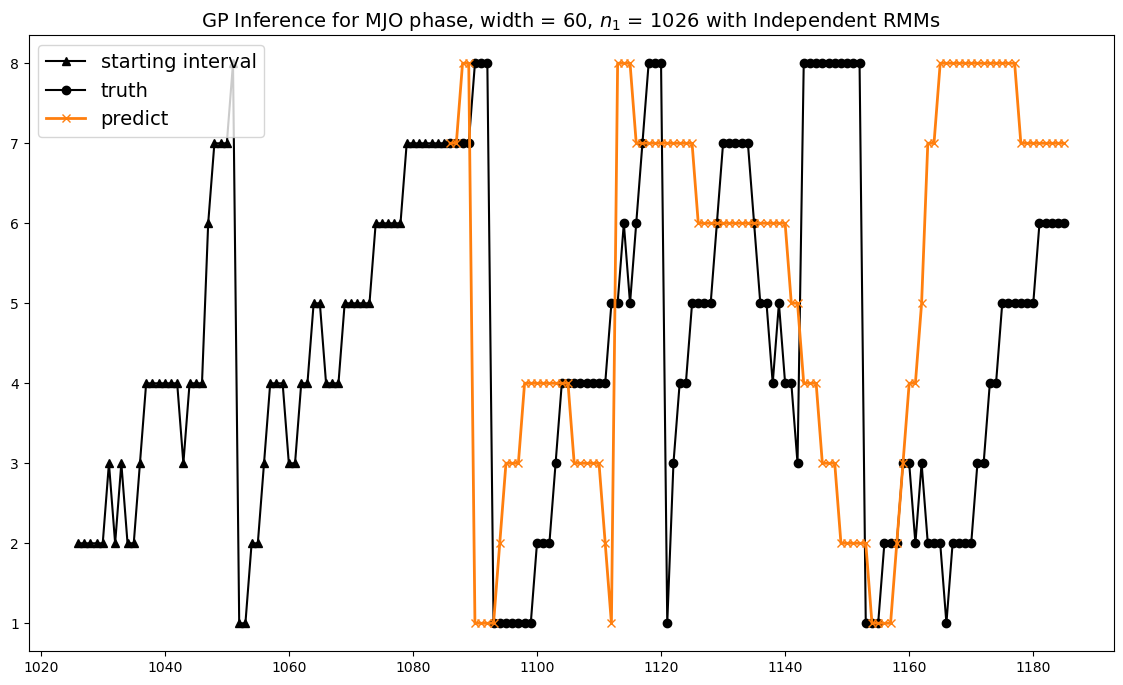

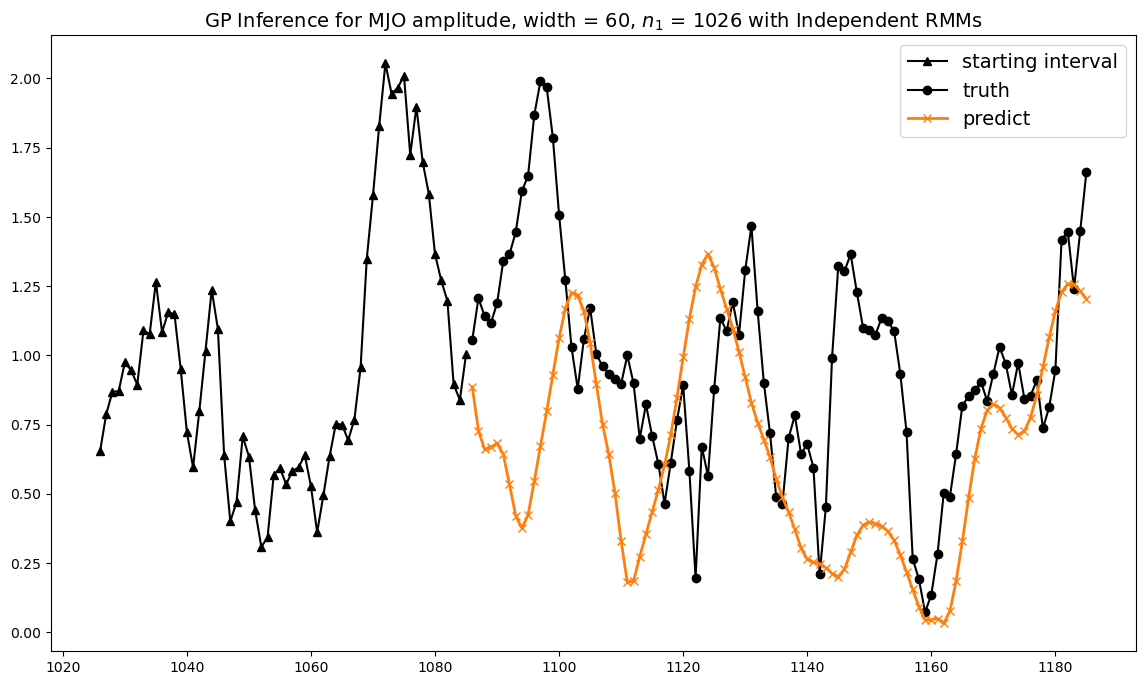

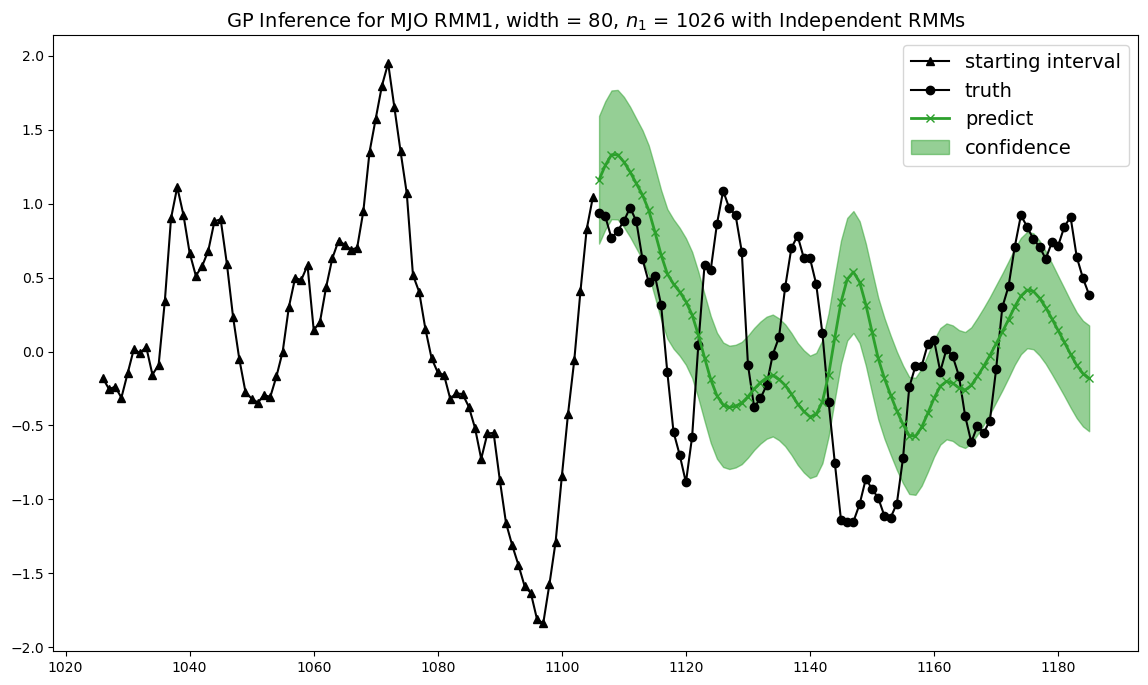

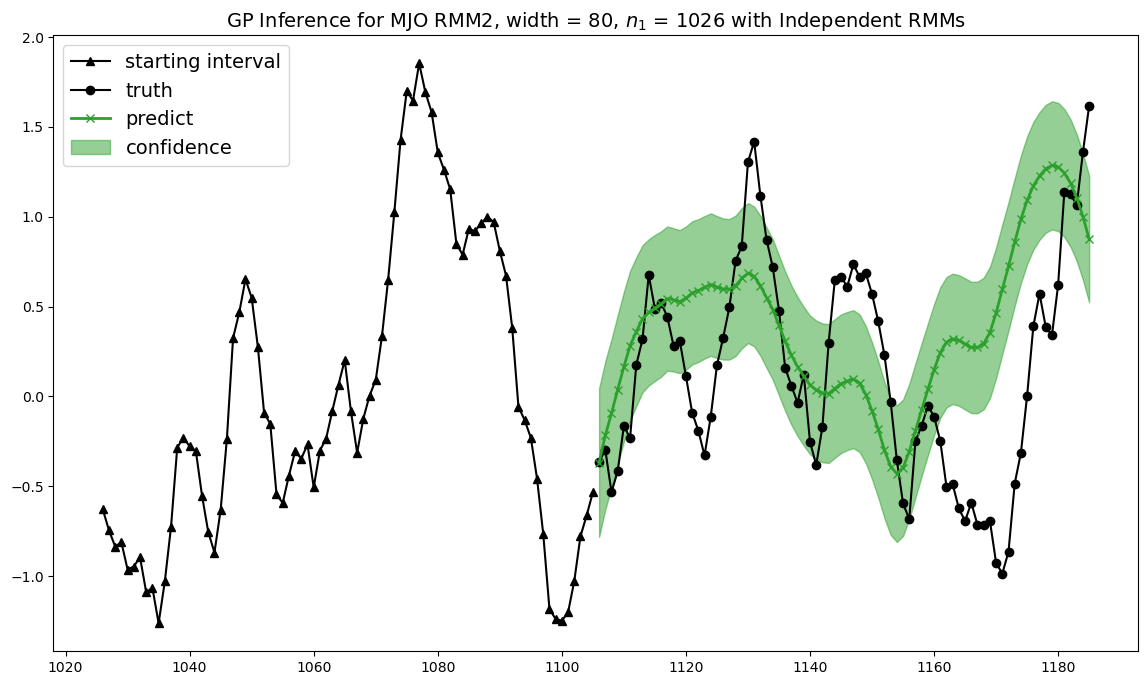

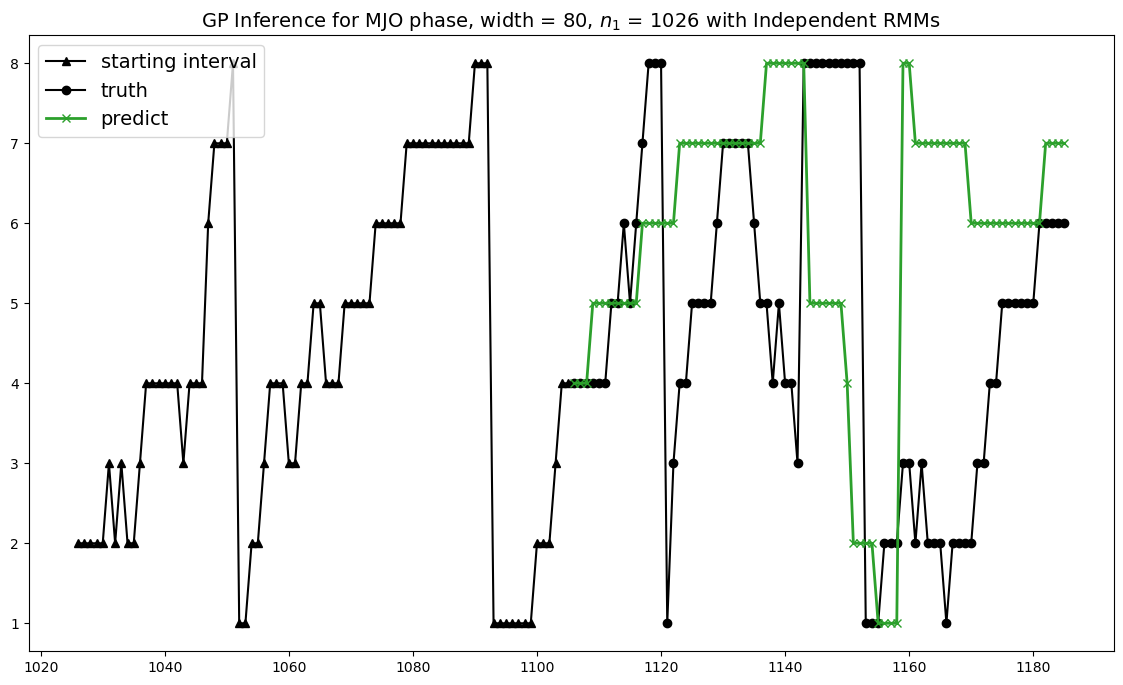

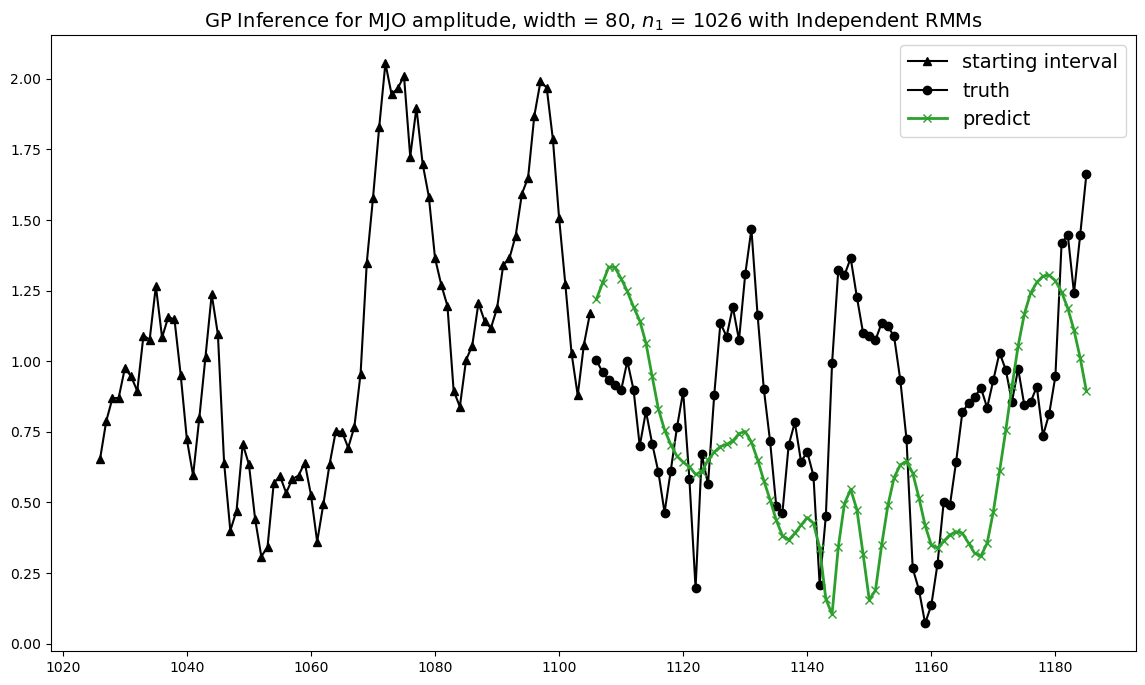

In [6]:
## Independent RMMs
dics_total = {}
for n1 in n1s:
    dics, dics_ids = dics_divide(new_datas, data_names, n1, m, n, c)
    dics_total[n1] = dics
    for width, color in zip(widths, plot_colors):
        mjo_model = gp_mjo(dics, dics_ids, kernel, width, n_iter, sigma_eps,fixed_noise)
        for i in range(4):  # data_names = ['year', 'month', 'day', 'RMM1', 'RMM2', 'phase', 'amplitude']
            data_name = data_names[3:][i]
            # initialize plot
            fig, ax = plt.subplots(1, 1, figsize=(14, 8))            
            
            if i <= 1:
                mjo_model.train_mjo(data_name)
                mjo_model.pred_mjo(data_name)
            if i == 2:
                mjo_model.rmm_to_phase()
            if i == 3:
                mjo_model.rmm_to_amplitude()
            mjo_model.plot_mjo(data_name, ax, color)

            ax.set_title(f'GP Inference for MJO {data_name}, width = {width}, $n_1$ = {n1} with Independent RMMs',fontsize=14)
            plt.show()

### Dependent RMMs Examples

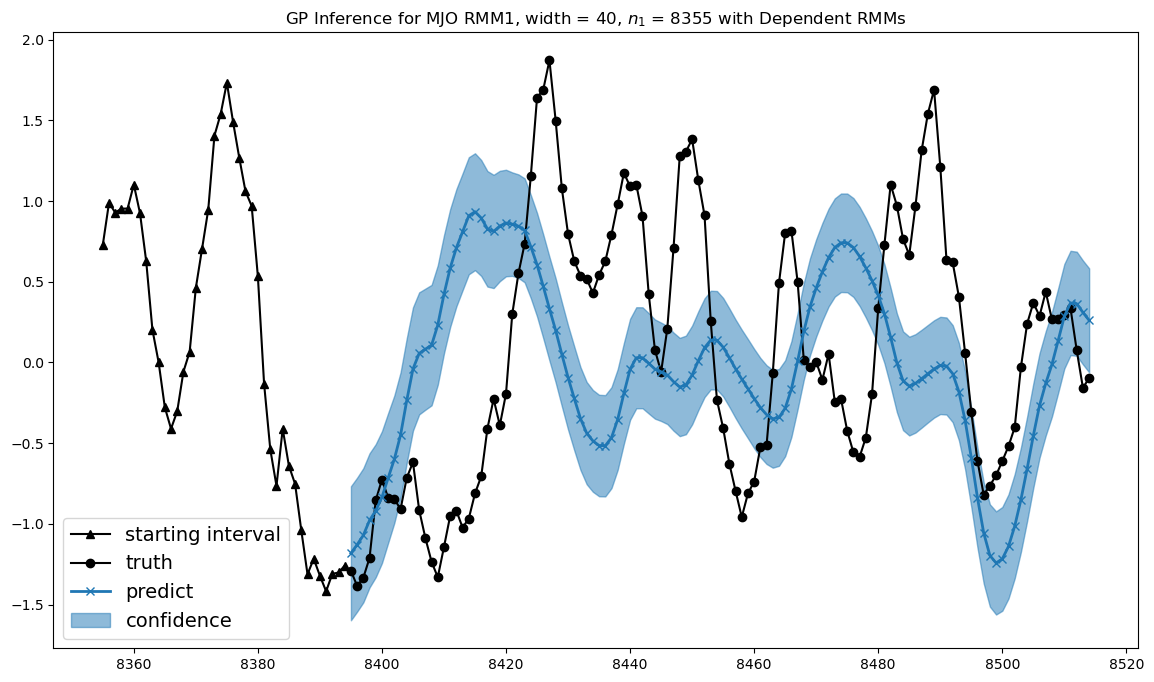

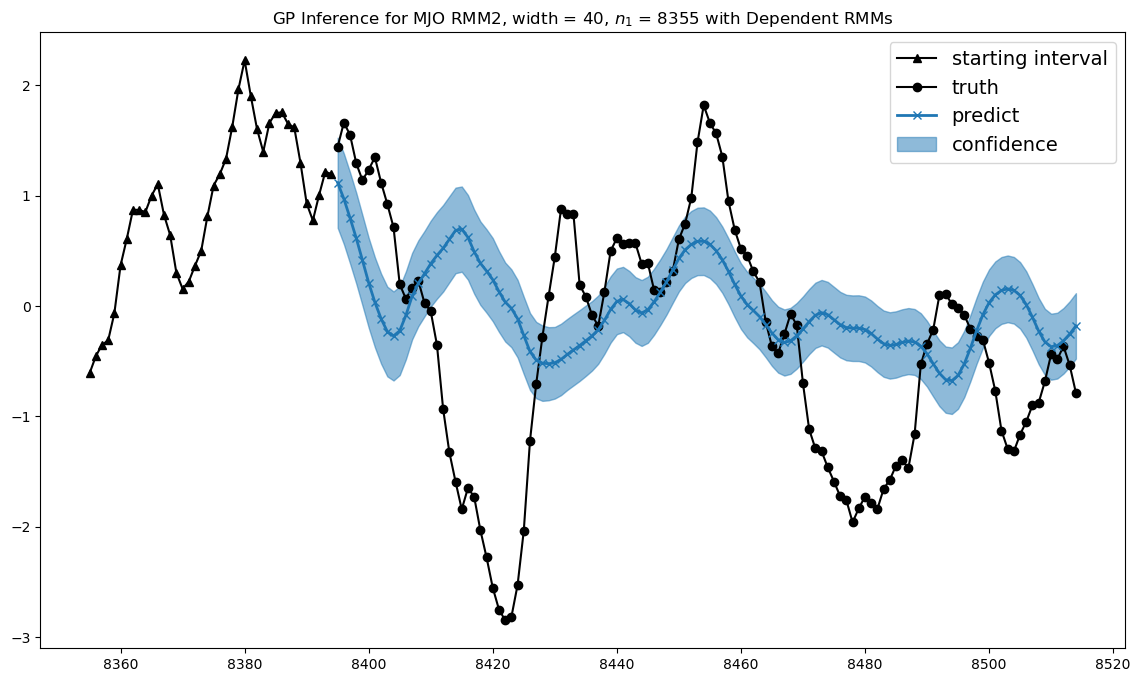

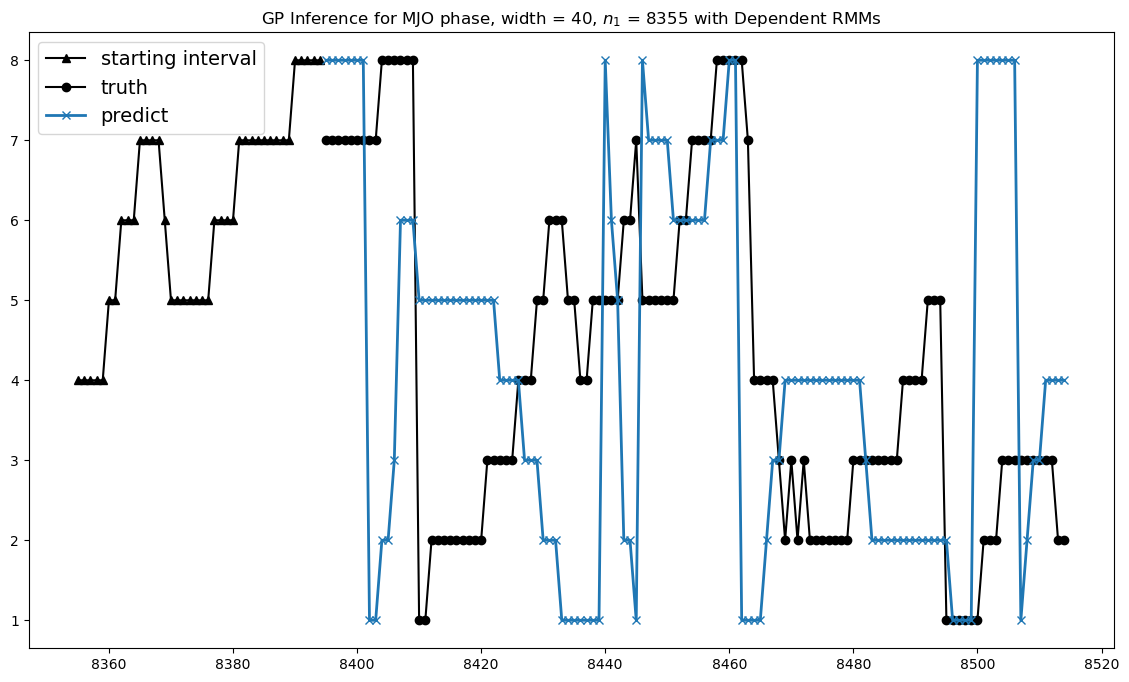

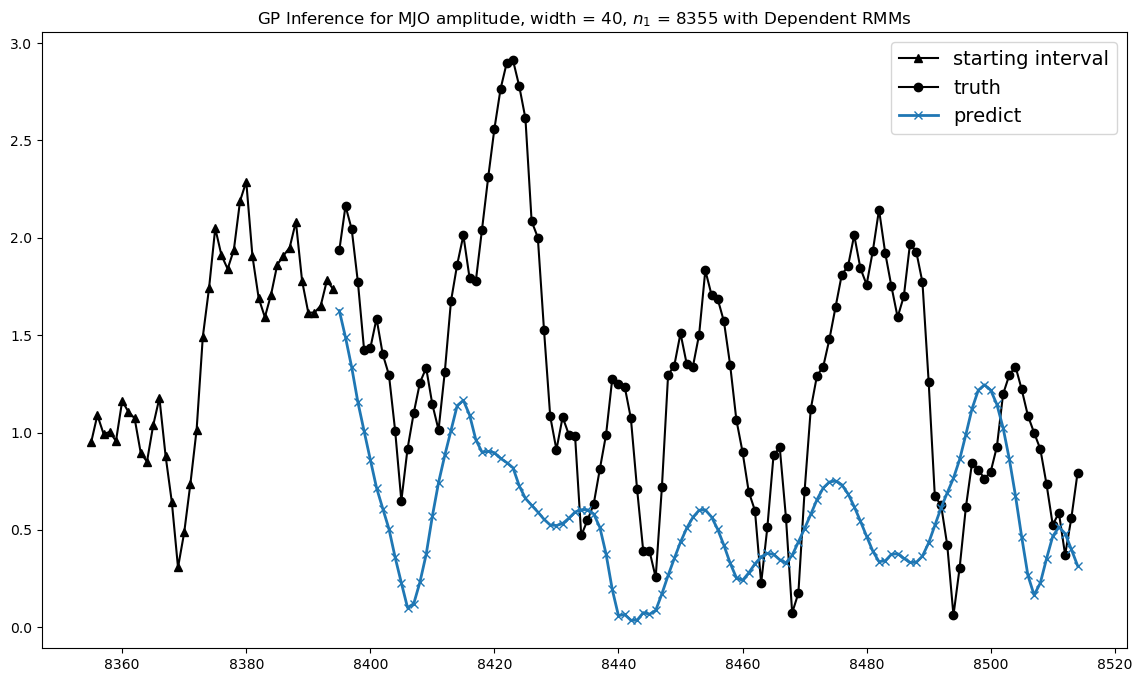

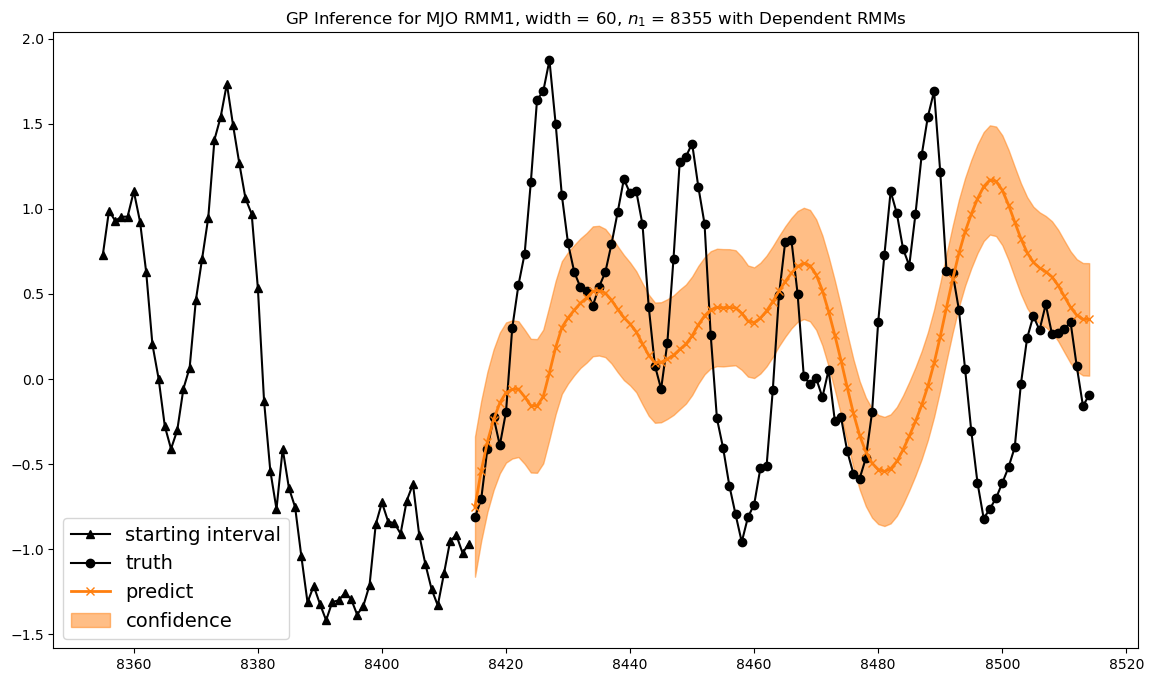

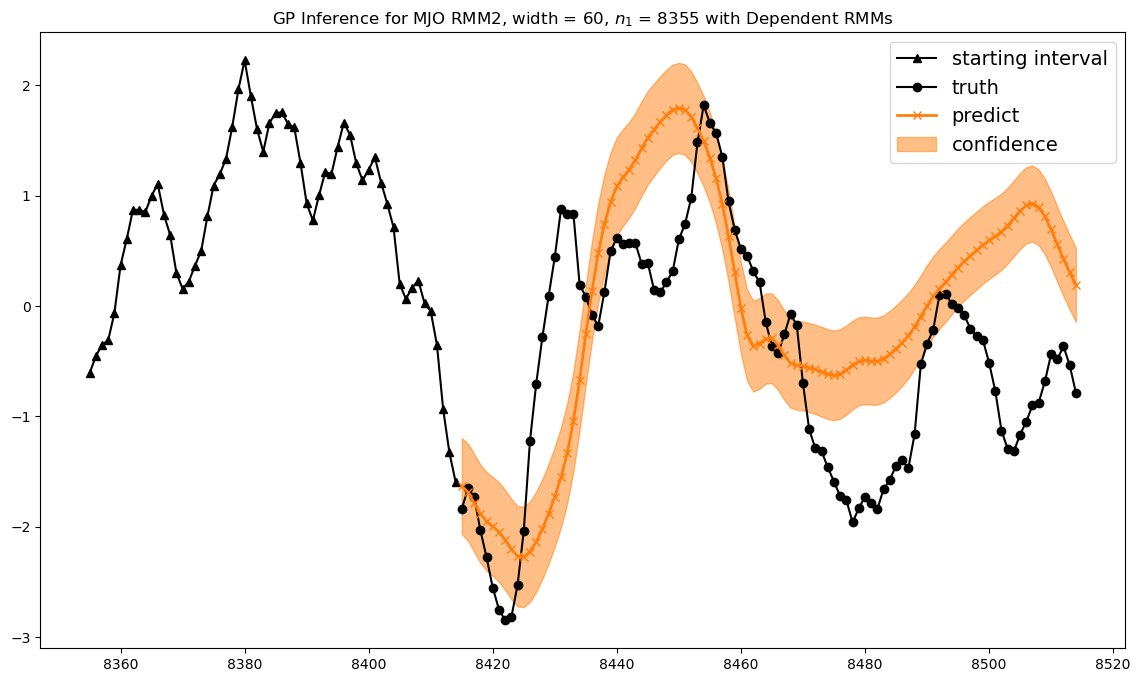

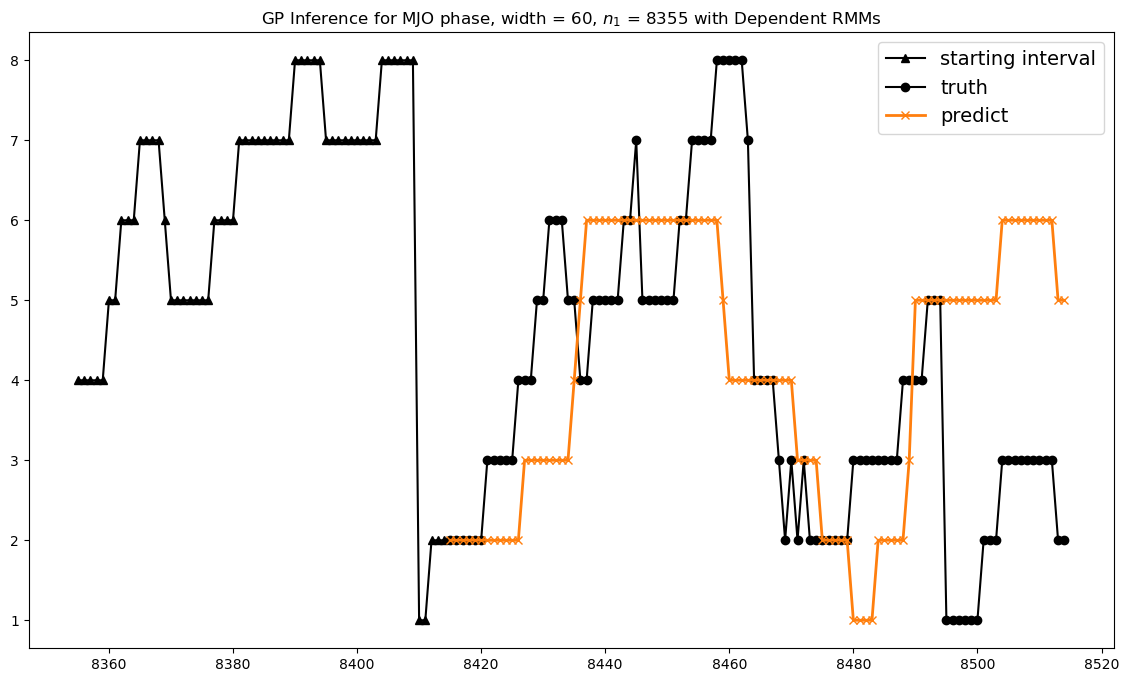

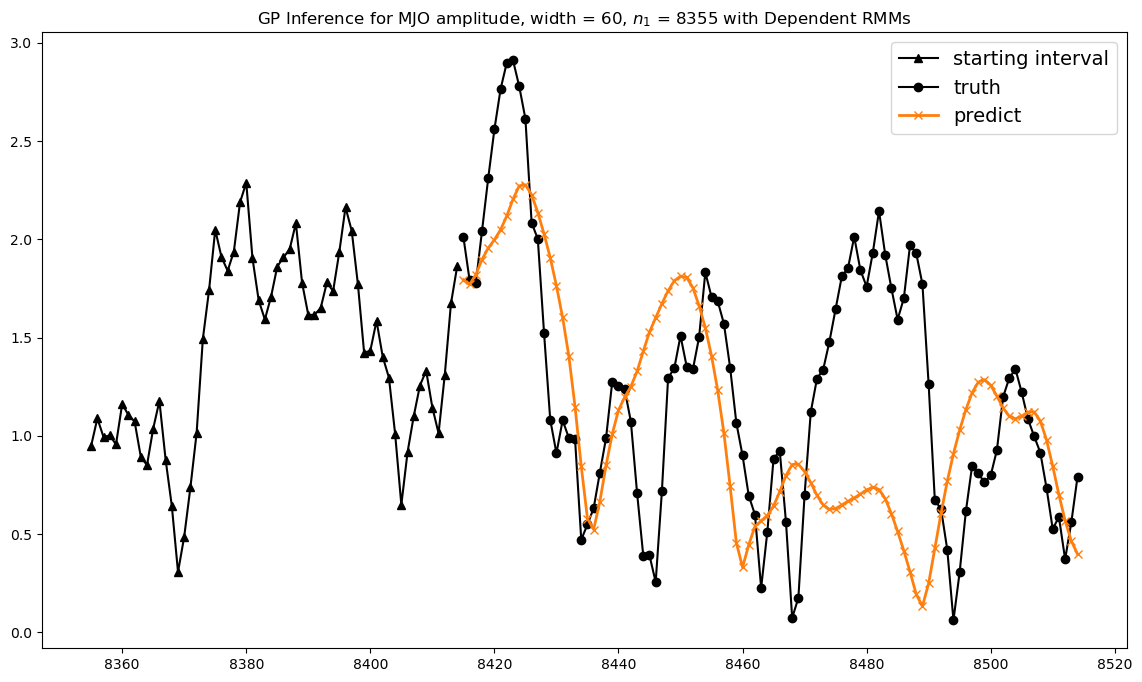

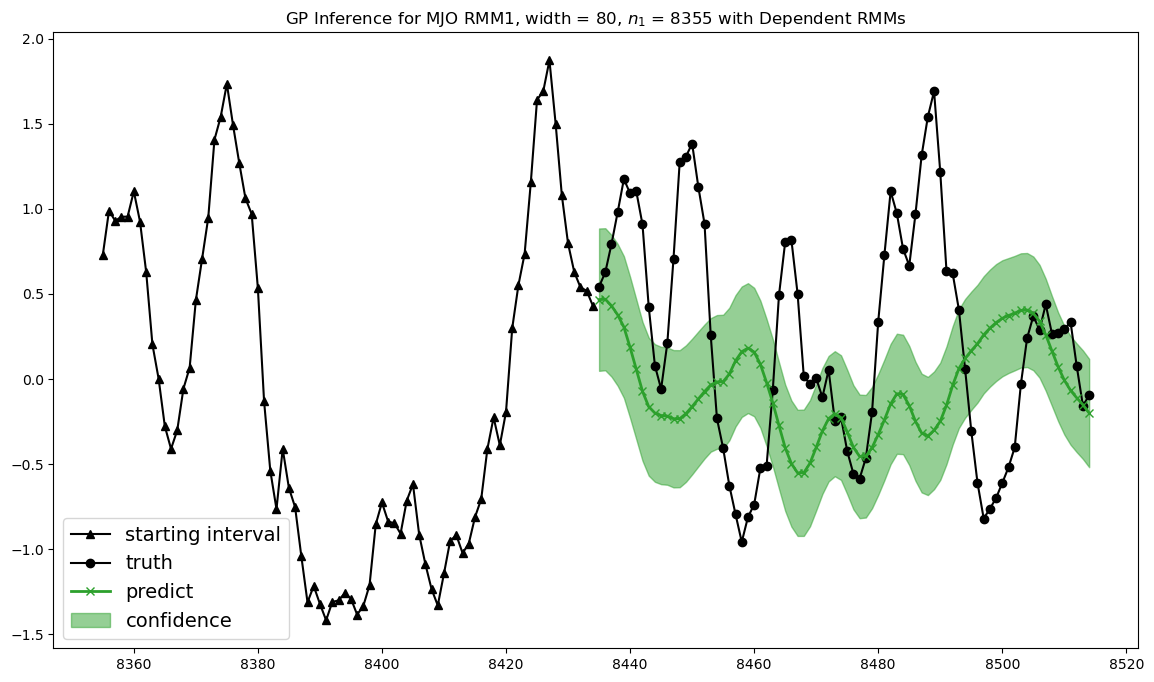

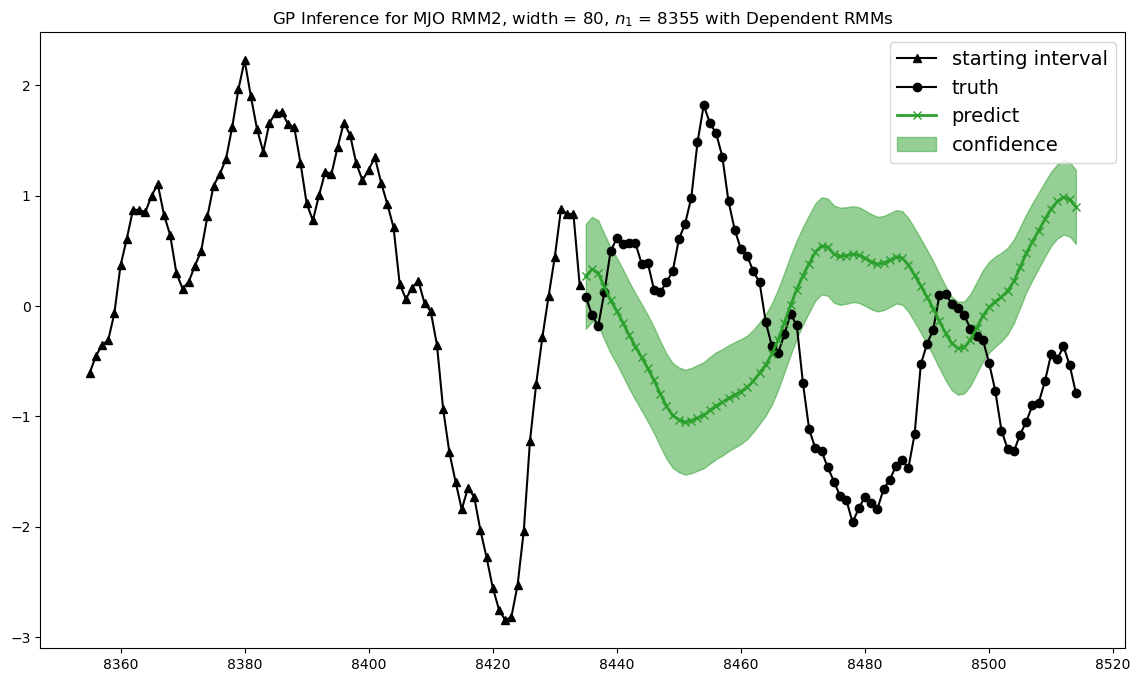

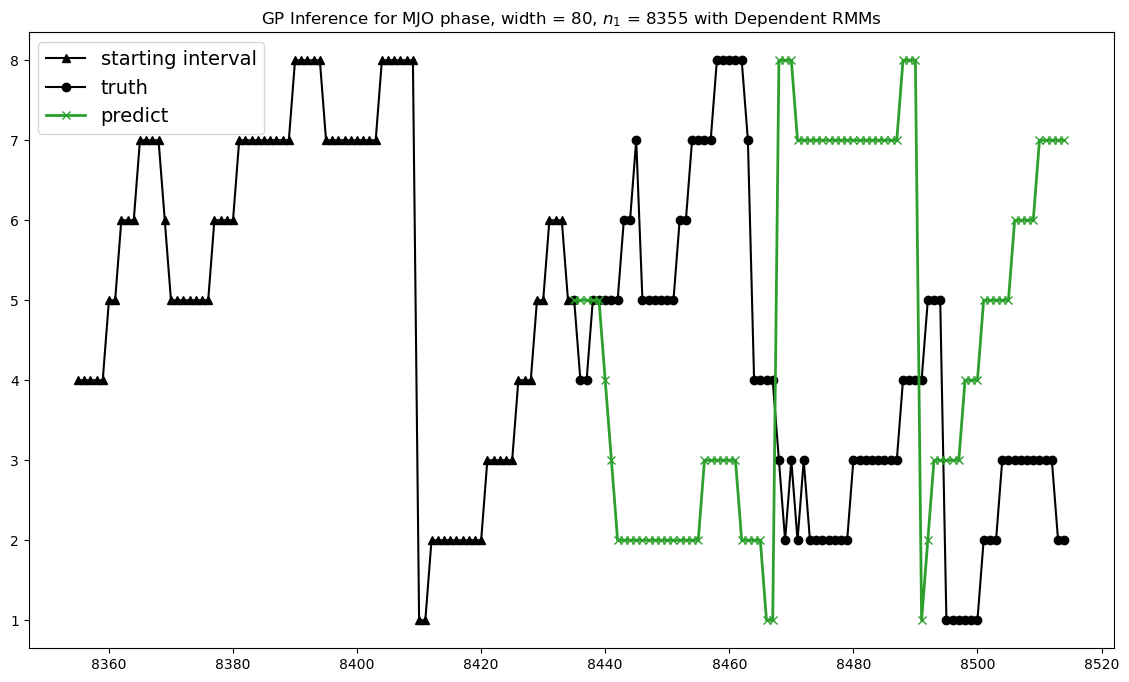

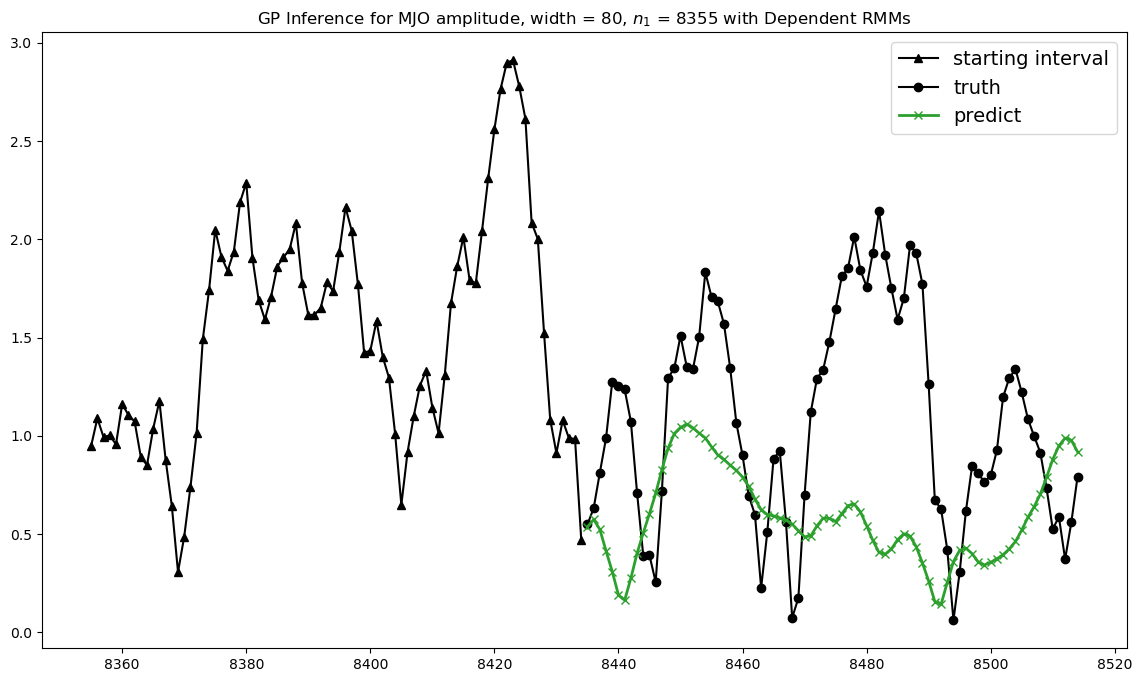

In [7]:
## Dependent RMMs
dics_total = {}
for n1 in n1s:
    dics, dics_ids = dics_divide(new_datas, data_names, n1, m, n, c)
    dics_total[n1] = dics
    for width, color in zip(widths, plot_colors): 
        mjo_model = gp_mjo(dics, dics_ids, kernel, width, n_iter, sigma_eps,fixed_noise)
        mjo_model.train_mjo(Depend=True)  
        for i in range(4):  # data_names = ['year', 'month', 'day', 'RMM1', 'RMM2', 'phase', 'amplitude']
            data_name = data_names[3:][i]        
            # initialize plot
            fig, ax = plt.subplots(1, 1, figsize=(14, 8))

            if i <= 1:               
                mjo_model.pred_mjo(data_name)
            if i == 2:
                mjo_model.rmm_to_phase()
            if i == 3:
                mjo_model.rmm_to_amplitude()
            mjo_model.plot_mjo(data_name, ax, color)

            ax.set_title(f'GP Inference for MJO {data_name}, width = {width}, $n_1$ = {n1} with Dependent RMMs')
            plt.show() 